# 📝 Project 01: Handwritten Digit Classifier (MNIST)

# Steps 
1. **Set up environment**

   * Install PyTorch and torchvision.
   * Make sure you can run Jupyter Notebook or a Python script.

2. **Load the MNIST dataset**

   * Use the standard MNIST dataset that has 60,000 training images and 10,000 test images.
   * Apply basic preprocessing: convert to tensors and normalize pixel values.

3. **Explore the dataset**

   * Visualize a few digit images with their labels.
   * Check dataset shape (28x28 grayscale images).

4. **Design the CNN model**

   * Build a simple Convolutional Neural Network with convolutional layers, activation functions (ReLU), pooling layers, and fully connected layers.
   * Output layer should have 10 neurons (for digits 0–9).

5. **Define training setup**

   * Choose a **loss function**: CrossEntropyLoss (for classification).
   * Choose an **optimizer**: Adam or SGD.
   * Set learning rate and number of epochs.

6. **Train the model**

   * For each batch of training data:

     1. Reset gradients.
     2. Pass data through the model (forward pass).
     3. Calculate loss between predictions and actual labels.
     4. Backpropagate the loss (compute gradients).
     5. Update weights using the optimizer.
   * Print loss per epoch to monitor training progress.

7. **Evaluate the model**

   * Test the trained model on the test dataset.
   * Measure accuracy: number of correct predictions divided by total predictions.

8. **Visualize results**

   * Plot training loss across epochs.
   * Show some test images along with predicted labels vs actual labels.

9. **Save the trained model**

   * Export model weights so you don’t need to retrain later.

10. **Optional extensions**

* Try adding dropout layers to reduce overfitting.
* Experiment with different optimizers (SGD, RMSprop).
* Deploy the model in a simple notebook UI where you can draw a digit and get prediction.

In [1]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# for visualizations
import matplotlib.pyplot as plt

In [2]:
# Setting up device and seed.
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
SEED = 42

In [3]:
train_data = datasets.MNIST(root="data", 
                            train=True, 
                            download=True, 
                            transform=ToTensor(), 
                            target_transform=None)

test_data = datasets.MNIST(root="data", 
                           train=False, 
                           download=True, 
                           transform=ToTensor(), 
                           target_transform=None)

In [4]:
len(train_data.data), len(test_data.data)

(60000, 10000)

In [5]:
image, label = train_data[0]
image.shape

torch.Size([1, 28, 28])

In [6]:
class_names = train_data.classes
len(class_names)

10

In [7]:
# image, label = train_data[0]

# # Showing one image 
# plt.imshow(image.squeeze(), cmap="gray")
# plt.title(class_names[label])
# plt.axis(False)

In [8]:
def plot_random_images(data: torch.Tensor, class_names: list[str]):
    fig = plt.figure(figsize=(9, 9))

    rows, cols = 4, 4

    for i in range(1, rows * cols + 1):
        # Getting images randomly
        random_index = torch.randint(0, len(data), size=[1]).item()

        # Getting image
        image, label = data[random_index]

        fig.add_subplot(rows, cols, i)
        plt.imshow(image.squeeze(), cmap="gray")
        plt.title(class_names[label])
        plt.axis(False)

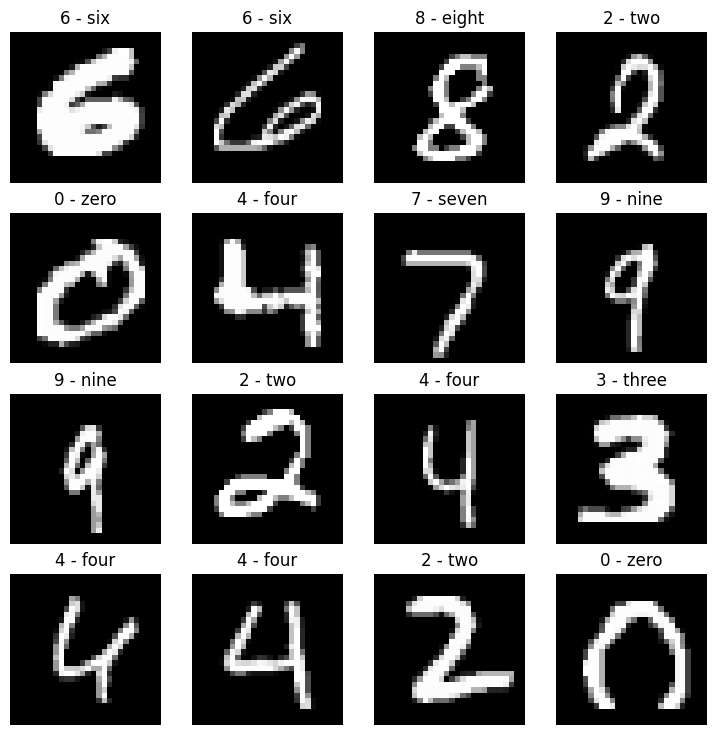

In [9]:
torch.manual_seed(SEED)
# Plotting train data
plot_random_images(data=train_data, class_names=class_names) 

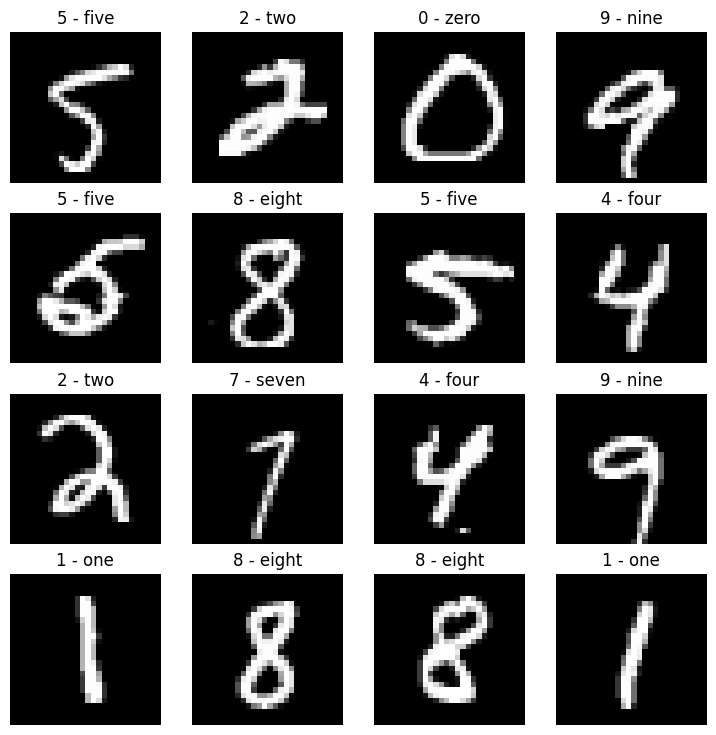

In [10]:
# SHOW SOME IMAGES IN TEST DATA
plot_random_images(data=test_data, class_names=class_names)

In [11]:
# preparing dataloader
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                            batch_size=BATCH_SIZE,
                            shuffle=False)

print(
    f"Length of the train dataloader: {len(train_dataloader)} of batches of {BATCH_SIZE}\n",
    f"Length of the test dataloader: {len(test_dataloader)} of batches of {BATCH_SIZE}"
)

Length of the train dataloader: 1875 of batches of 32
 Length of the test dataloader: 313 of batches of 32


In [12]:
train_feautures_batch, train_labels_batch = next(iter(train_dataloader))
train_feautures_batch.shape

torch.Size([32, 1, 28, 28])

(-0.5, 27.5, 27.5, -0.5)

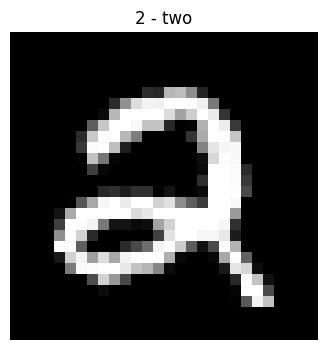

In [13]:
# torch.manual_seed(SEED)
random_index = torch.randint(0, len(train_feautures_batch), size=[1]).item()
image, label = train_feautures_batch[random_index], train_labels_batch[random_index]

plt.figure(figsize=(4, 4))
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)

## 🔍 What is TinyVGG?

**TinyVGG** is a simplified version of the **VGG network architecture**, often used for educational and experimental purposes in computer vision.

The key idea of **VGG-like models** is:

- 📦 Stack multiple **convolutional layers** (with small filters, usually `3×3`).
- ⚡ Use **ReLU activation** after each convolution.
- 🔽 Apply **max pooling** to reduce spatial dimensions while keeping key features.
- 📐 Flatten the output and pass through **fully connected layers** for classification.

TinyVGG follows this idea but keeps it **much smaller** so it can train faster on small datasets like **MNIST**.

---

### General TinyVGG Block

```

Conv → ReLU
Conv → ReLU
MaxPool

```

*(repeat for more blocks, then add fully connected layers at the end)*


## Here is the Archtecture diagram for TinyVGG
![TinyVGG](img_assets/tinny-vgg-archtecture.webp)

In [14]:
class TinnyVGG(nn.Module):
    """
    TinyVGG Model Architecture

       Args:
          input_shape (int):  Color channels.
          hidden_units (int): Number of hidden units/filters used in convolutional layers.
          output_shape (int): Number of output classes (e.g., 10 for digit classification).

       Description:
         Implements a simplified VGG-style CNN (TinyVGG), consisting of stacked 
         convolutional layers with ReLU activations, max pooling, and fully connected layers.
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
       super().__init__()

       self.block_1 = nn.Sequential(
           nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, 
                     kernel_size=3, stride=1, padding=1),
           nn.ReLU(),
           nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,
                    kernel_size=3, stride=1, padding=1),
           nn.ReLU(),
           nn.MaxPool2d(kernel_size=2, stride=2)
       )

       self.block_2 = nn.Sequential(
           nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,
                    kernel_size=3, stride=1, padding=1),
           nn.ReLU(),
           nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,
                    kernel_size=3, stride=1, padding=1),
           nn.ReLU(),
           nn.MaxPool2d(kernel_size=2, stride=2)
       )

       self.classifier = nn.Sequential(
           nn.Flatten(),
           nn.Linear(in_features=hidden_units * 7 * 7, 
                     out_features=len(class_names), )
       )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # First conv block 
        x = self.block_1(x)

        # Second conv block
        x = self.block_2(x)

        # classfication(dense) layer
        x = self.classifier(x)

        return x

In [15]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: nn.Module, 
               optimizer: torch.optim.Optimizer, 
               device: torch.device = device):
    model.train()

    train_acc, train_loss = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        # moving the data to device
        X, y = X.to(device), y.to(device)

        # 1.Forward pass
        y_logits = model(X)

        # 2.Calculate and accumlate loss
        loss = loss_fn(y_logits, y)
        train_loss += loss.item()

        # 3.Optimizer zero grad
        optimizer.zero_grad()

        # 4.loss backward
        loss.backward()

        # 5.optimizer step
        optimizer.step()

        # Calculating accuracy
        y_pred_class = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_logits)

    # finding average loss and accuracy for the batch
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return {
        "train_loss": train_loss,
        "train_acc": train_acc
    }
        

In [16]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module, 
              device: torch.device = device):
    model.eval()

    test_acc, test_loss = 0, 0 

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            # moving data to target device(either cpu or gpu)
            X, y = X.to(device), y.to(device)

            # Getting logits
            test_logits = model(X)


            # Calculate and accumulate loss
            loss = loss_fn(test_logits, y)

            test_loss += loss.item()

            # Calculate accuracy
            test_pred_class = torch.argmax(torch.softmax(test_logits, dim=1), dim=1)
            test_acc += (test_pred_class == y).sum().item() / len(test_logits) 

        # calculate avg acc and loss
        test_acc /= len(dataloader)
        test_loss /= len(dataloader)

    return {
        "test_acc": test_acc,
        "test_loss": test_loss
    }           

In [17]:
from tqdm.auto import tqdm

def train_model(model: torch.nn.Module, 
                train_dataloader: torch.utils.data.DataLoader,
                test_dataloader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                optimizer: torch.optim.Optimizer,
                epochs: int = 5,
                device: torch.device = device):
    results = {
        "train_acc": [],
        "train_loss": [],
        "test_acc": [],
        "test_loss": []
    }

    for epoch in tqdm(range(epochs)):
        train_results = train_step(model, train_dataloader, 
                                   loss_fn, optimizer, device)

        test_results = test_step(model, test_dataloader, 
                                 loss_fn, device)

        # showing whats happening
        print(
            f"Epoch: {epoch + 1} | ",
            f"train loss: {train_results['train_loss']:.4f} | ",
            f"train acc: {train_results['train_acc']:.4f} | ",
            f"test loss: {test_results['test_loss']:.4} | ",
            f"test acc: {test_results['test_acc']:.4f}"
        )


        results["train_acc"].append(train_results["train_acc"])
        results["train_loss"].append(train_results["train_loss"])
        results["test_acc"].append(test_results["test_acc"])
        results["test_loss"].append(test_results["test_loss"])

    return results

/opt/anaconda3/envs/env_pytorch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
model_0 = TinnyVGG(input_shape=1, 
                   hidden_units=10, 
                   output_shape=len(class_names)).to(device)

next(model_0.parameters()).device

device(type='mps', index=0)

In [19]:
from torchinfo import summary

summary(model=model_0, input_size=(32, 1, 28, 28), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
TinnyVGG                                 [32, 10]                  --
├─Sequential: 1-1                        [32, 10, 14, 14]          --
│    └─Conv2d: 2-1                       [32, 10, 28, 28]          100
│    └─ReLU: 2-2                         [32, 10, 28, 28]          --
│    └─Conv2d: 2-3                       [32, 10, 28, 28]          910
│    └─ReLU: 2-4                         [32, 10, 28, 28]          --
│    └─MaxPool2d: 2-5                    [32, 10, 14, 14]          --
├─Sequential: 1-2                        [32, 10, 7, 7]            --
│    └─Conv2d: 2-6                       [32, 10, 14, 14]          910
│    └─ReLU: 2-7                         [32, 10, 14, 14]          --
│    └─Conv2d: 2-8                       [32, 10, 14, 14]          910
│    └─ReLU: 2-9                         [32, 10, 14, 14]          --
│    └─MaxPool2d: 2-10                   [32, 10, 7, 7]            --
├─Sequentia

In [20]:
# loss and optimizer initialization
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

In [21]:
torch.manual_seed(SEED)
torch.mps.manual_seed(SEED)

from timeit import default_timer as timer

start_time = timer()


results = train_model(model=model_0, 
            train_dataloader=train_dataloader, 
            test_dataloader=test_dataloader, 
            loss_fn=loss_fn, 
            optimizer=optimizer, 
            device=device)

end_time = timer()

print(f"Total training time: {(end_time - start_time):.4f} seconds")

 20%|█████████                                    | 1/5 [01:14<04:56, 74.12s/it]

Epoch: 1 |  train loss: 1.7151 |  train acc: 0.3817 |  test loss: 0.3875 |  test acc: 0.8816


 40%|██████████████████                           | 2/5 [02:28<03:42, 74.11s/it]

Epoch: 2 |  train loss: 0.2111 |  train acc: 0.9364 |  test loss: 0.1172 |  test acc: 0.9630


 60%|███████████████████████████                  | 3/5 [03:41<02:27, 73.94s/it]

Epoch: 3 |  train loss: 0.1193 |  train acc: 0.9632 |  test loss: 0.08904 |  test acc: 0.9715


 80%|████████████████████████████████████         | 4/5 [04:55<01:13, 73.76s/it]

Epoch: 4 |  train loss: 0.0943 |  train acc: 0.9710 |  test loss: 0.07765 |  test acc: 0.9756


100%|█████████████████████████████████████████████| 5/5 [06:09<00:00, 73.81s/it]

Epoch: 5 |  train loss: 0.0787 |  train acc: 0.9761 |  test loss: 0.06102 |  test acc: 0.9797
Total training time: 369.0579 seconds


In [22]:
next(model_0.parameters()).device

device(type='mps', index=0)

In [23]:
class TinyVGGWithDropout(nn.Module):
    """
    Tinny VGG Model Architecture with Dropout

    Args:
        input_shape (int): Number of input channels (eg: 1 for grayscale images)
        hidden_units (int): Number of hidden units/ filters used in convulutional layer
        output_shape (int): Number of output classes.
        dropout_rate (float): rate of dropout

    Description:
        Implements a simplified VGG-style CNN (TinyVGG), consisting of stacked
        convolutional layers with ReLU activations, max pooling, dropout, and fully connected layers.
    """

    def __init__(self, 
                 input_shape: int, 
                 hidden_units: int, 
                 output_shape: int, 
                 dropout_rate: float = 0.5) -> None:
        super().__init__()

        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units,
                     kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,
                     kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=dropout_rate)
        )

        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,
                     kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,
                     kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=dropout_rate)
        )

        self.classfier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 7 * 7, 
                      out_features=len(class_names)),
            nn.Dropout(p=dropout_rate)
        )


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # first conv block
        x = self.block_1(x)

        # second conv block
        x = self.block_2(x)

        # classfication layer
        x = self.classfier(x)

        return x

In [24]:
model_sgd = TinyVGGWithDropout(input_shape=1, 
                             hidden_units=10, 
                             output_shape=len(class_names)).to(device)

model_adam = TinyVGGWithDropout(input_shape=1, 
                                hidden_units=10,
                               output_shape=len(class_names)).to(device)

In [25]:
summary(model_sgd, input_size=(32, 1, 28, 28), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGGWithDropout                       [32, 10]                  --
├─Sequential: 1-1                        [32, 10, 14, 14]          --
│    └─Conv2d: 2-1                       [32, 10, 28, 28]          100
│    └─ReLU: 2-2                         [32, 10, 28, 28]          --
│    └─Conv2d: 2-3                       [32, 10, 28, 28]          910
│    └─ReLU: 2-4                         [32, 10, 28, 28]          --
│    └─MaxPool2d: 2-5                    [32, 10, 14, 14]          --
│    └─Dropout: 2-6                      [32, 10, 14, 14]          --
├─Sequential: 1-2                        [32, 10, 7, 7]            --
│    └─Conv2d: 2-7                       [32, 10, 14, 14]          910
│    └─ReLU: 2-8                         [32, 10, 14, 14]          --
│    └─Conv2d: 2-9                       [32, 10, 14, 14]          910
│    └─ReLU: 2-10                        [32, 10, 14, 14]          --
│    └─MaxP

In [26]:
next(model_adam.parameters()).device

device(type='mps', index=0)

In [28]:
sgd_optimizer = torch.optim.SGD(params=model_sgd.parameters(), lr=0.01)
adam_optimizer = torch.optim.Adam(params=model_adam.parameters(), lr=0.01)

In [30]:
torch.manual_seed(SEED)
torch.mps.manual_seed(SEED)

from timeit import default_timer as timer

start_time = timer()

sgd_results = train_model(model=model_sgd, 
                         train_dataloader=train_dataloader,
                         test_dataloader=test_dataloader, 
                         loss_fn=loss_fn,
                         optimizer=sgd_optimizer)

end_time = timer()

print(f"Total time taken: {(end_time - start_time):.4f}")

 20%|█████████                                    | 1/5 [01:35<06:20, 95.13s/it]

Epoch: 1 |  train loss: 1.9498 |  train acc: 0.2775 |  test loss: 0.6889 |  test acc: 0.9088


 40%|██████████████████                           | 2/5 [03:10<04:46, 95.36s/it]

Epoch: 2 |  train loss: 1.2868 |  train acc: 0.5121 |  test loss: 0.3619 |  test acc: 0.9347


 60%|███████████████████████████                  | 3/5 [04:45<03:09, 94.94s/it]

Epoch: 3 |  train loss: 1.1917 |  train acc: 0.5377 |  test loss: 0.2476 |  test acc: 0.9487


 80%|████████████████████████████████████         | 4/5 [06:21<01:35, 95.64s/it]

Epoch: 4 |  train loss: 1.1524 |  train acc: 0.5416 |  test loss: 0.2888 |  test acc: 0.9538


100%|█████████████████████████████████████████████| 5/5 [07:55<00:00, 95.15s/it]

Epoch: 5 |  train loss: 1.1269 |  train acc: 0.5461 |  test loss: 0.2202 |  test acc: 0.9570
Total time taken: 475.7507


In [31]:
torch.manual_seed(SEED)
torch.mps.manual_seed(SEED)

from timeit import default_timer as timer

start_time = timer()

adam_results = train_model(model=model_adam, 
                          train_dataloader=train_dataloader,
                          test_dataloader=test_dataloader,
                          loss_fn=loss_fn,
                          optimizer=adam_optimizer)

end_time = timer()

print(f"Total time taken: {(end_time - start_time):.4f}")

 20%|████████▊                                   | 1/5 [01:42<06:48, 102.05s/it]

Epoch: 1 |  train loss: 2.3035 |  train acc: 0.1047 |  test loss: 2.302 |  test acc: 0.1032


 40%|██████████████████                           | 2/5 [03:20<04:59, 99.85s/it]

Epoch: 2 |  train loss: 2.3038 |  train acc: 0.1026 |  test loss: 2.303 |  test acc: 0.1135


 60%|██████████████████████████▍                 | 3/5 [05:02<03:21, 100.94s/it]

Epoch: 3 |  train loss: 2.3035 |  train acc: 0.1069 |  test loss: 2.303 |  test acc: 0.1010


 80%|███████████████████████████████████▏        | 4/5 [07:07<01:50, 110.50s/it]

Epoch: 4 |  train loss: 2.3038 |  train acc: 0.1038 |  test loss: 2.302 |  test acc: 0.1135


100%|████████████████████████████████████████████| 5/5 [09:19<00:00, 111.89s/it]

Epoch: 5 |  train loss: 2.3037 |  train acc: 0.1053 |  test loss: 2.303 |  test acc: 0.1032
Total time taken: 559.4456


In [32]:
from typing import Dict, List

def plot_loss_curves(results: Dict[str, List[float]]):
    """
    Plot loss and accuracy curves for results
    """

    train_loss = results["train_loss"]
    test_loss = results["test_loss"]

    train_acc = results["train_acc"]
    test_acc = results["test_acc"]

    epochs = range(len(train_loss))

    plt.figure(figsize=(15, 7))

    # plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label=["train_loss"])
    plt.plot(epochs, test_loss, label=["test_loss"])
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend();

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label=["train_accuracy"])
    plt.plot(epochs, test_acc, label=["test_accuracy"])
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend();

### Plotting graph for SGD optimizer function

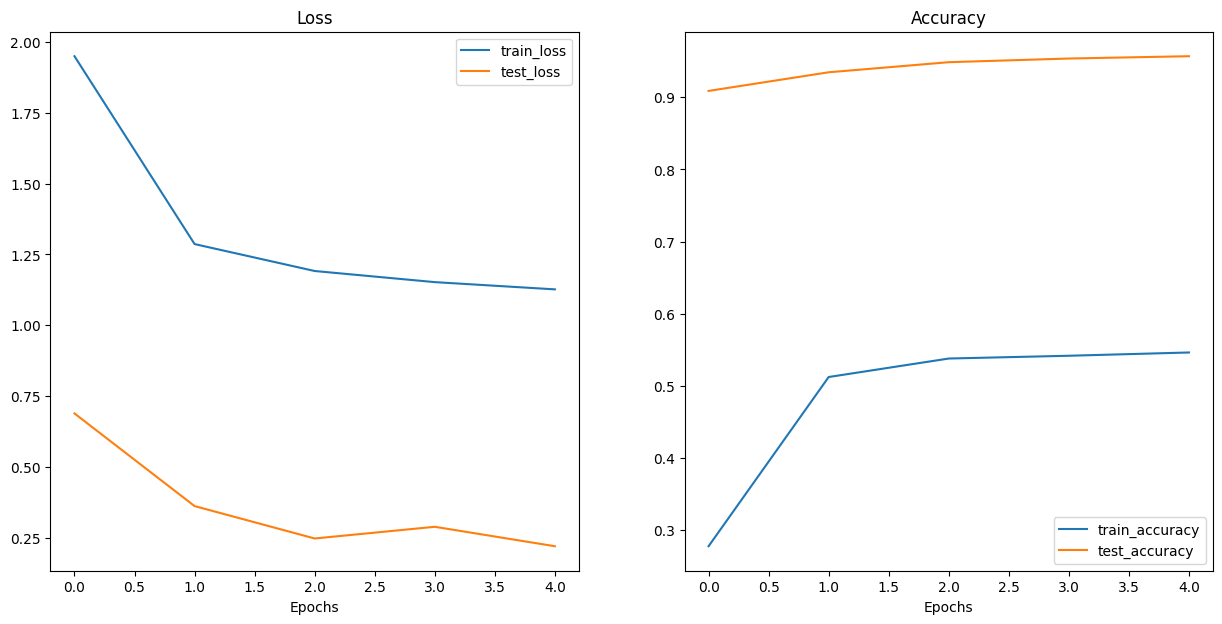

In [35]:
plot_loss_curves(sgd_results)

### Plotting graph for Adam optimizer

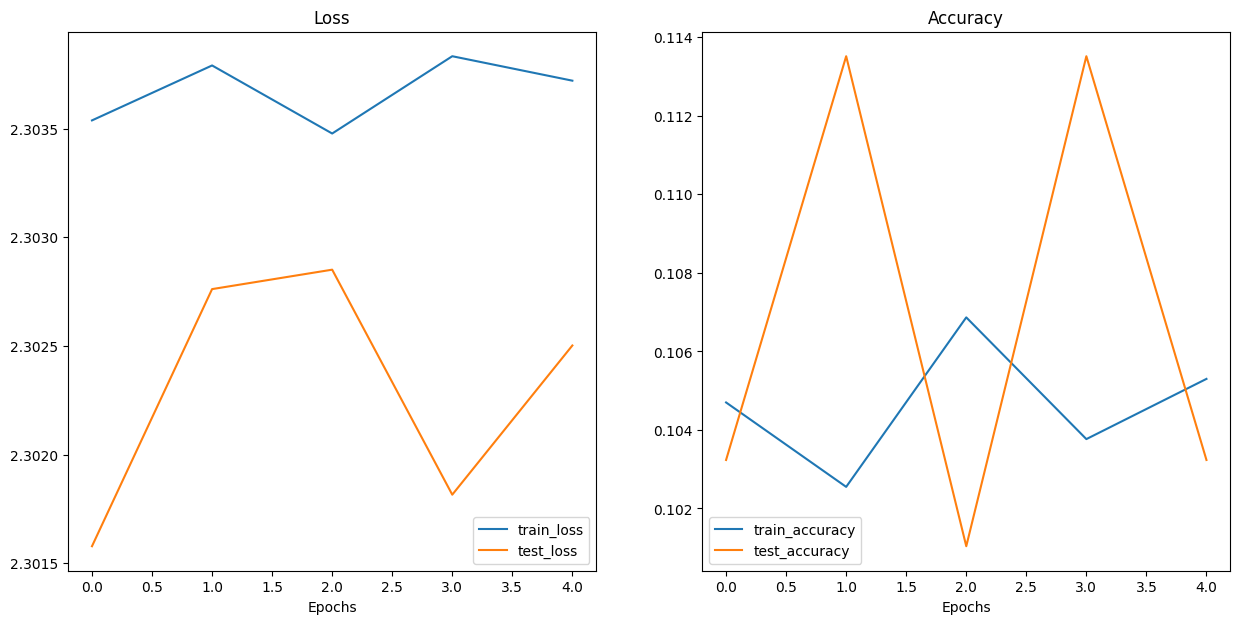

In [36]:
plot_loss_curves(adam_results)

# Results for model without dropout

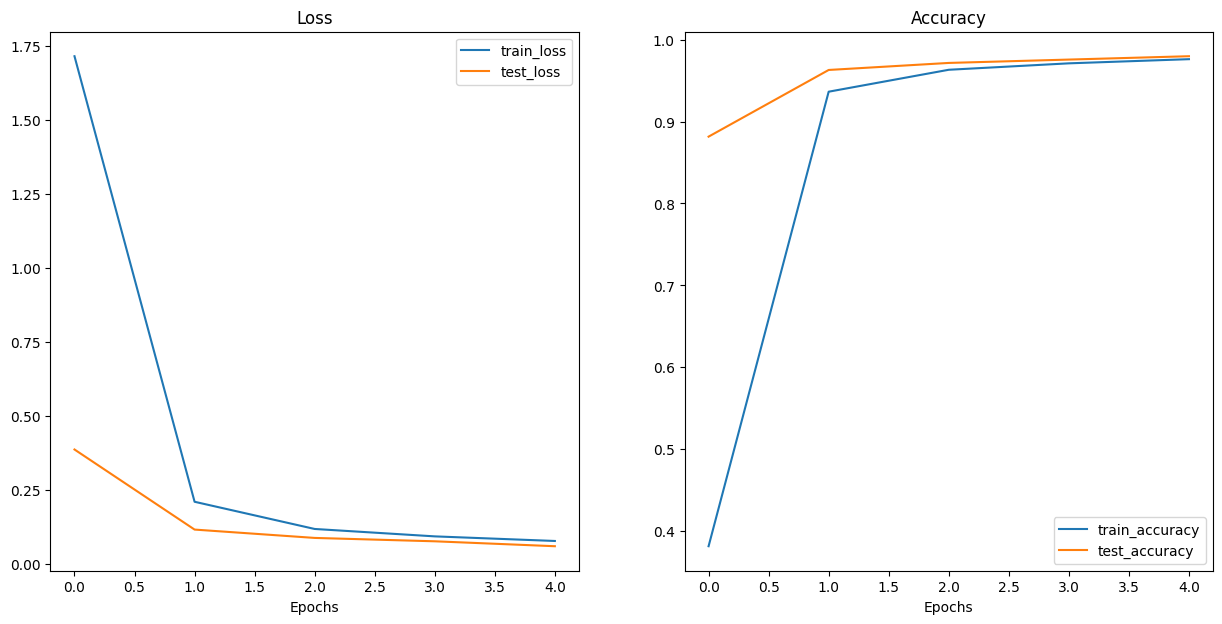

In [37]:
plot_loss_curves(results)

In [38]:
import pandas as pd

model_1_df = pd.DataFrame(results)
model_1_df

,train_acc,train_loss,test_acc,test_loss
0,0.381717,1.715130,0.881589,0.387531
1,0.936433,0.211082,0.962959,0.117210
2,0.963200,0.119264,0.971546,0.089041
3,0.971050,0.094263,0.975639,0.077645
4,0.976133,0.078743,0.979732,0.061020


In [62]:
import torch 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evalulate_model(model: torch.nn.Module, 
                    dataloader: torch.utils.data.DataLoader, 
                    class_names: list[str], 
                    device: torch.device = device, 
                    show_samples: bool = True, 
                    num_samples: int = 6):
    """
    Evaluate a trained model on a given dataloader and print metrics.

    Args:
        model (torch.nn.Module): Trained PyTorch model.
        dataloader (torch.utils.data.DataLoader): Dataloader (e.g., test set).
        class_names (list): List of class names for labels.
        device (str): "cpu", "cuda", or "mps".
        show_samples (bool): Whether to show sample predictions.
        num_samples (int): Number of images to visualize if show_samples=True.
    """

    model.eval()

    y_preds, y_true = [], []

    with torch.inference_mode():
        for X, y  in dataloader:
            X, y = X.to(device), y.to(device)

            y_logits = model(X)
            y_pred = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)

            # print(y_pred)


            y_preds.extend(y_pred.cpu().numpy())
            y_true.extend(y.cpu().numpy())

    # compute metrics
    acc = accuracy_score(y_true, y_preds)
    print(f"✅ Accuracy: {acc:.2%}\n")

    print(f"📊 Classification Report:")
    print(classification_report(y_true, y_preds, target_names=class_names))

    print(f"📊 Confussion matrix:")
    cm = confusion_matrix(y_true, y_preds)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion matrix")
    plt.show()

✅ Accuracy: 97.97%

📊 Classification Report:
              precision    recall  f1-score   support

    0 - zero       0.98      0.99      0.98       980
     1 - one       0.99      0.99      0.99      1135
     2 - two       0.98      0.98      0.98      1032
   3 - three       0.98      0.98      0.98      1010
    4 - four       0.99      0.97      0.98       982
    5 - five       0.98      0.98      0.98       892
     6 - six       0.99      0.98      0.99       958
   7 - seven       0.98      0.97      0.98      1028
   8 - eight       0.97      0.98      0.97       974
    9 - nine       0.96      0.98      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

📊 Confussion matrix:


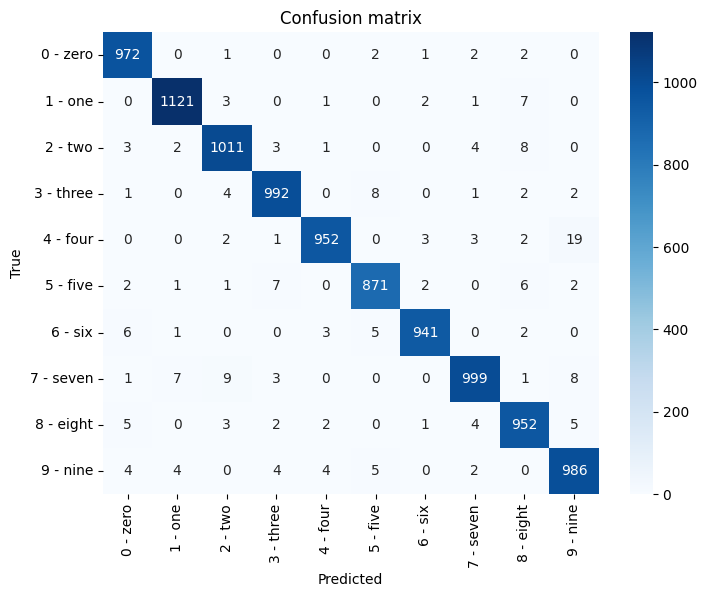

In [64]:
evalulate_model(model_0, test_dataloader, class_names, device)

In [65]:
import matplotlib.pyplot as plt
import torch

def show_predictions(model, dataloader, class_names, device, num_samples=6):
    """
    Show some predictions from a dataloader.

    Args:
        model (nn.Module): Trained model.
        dataloader (torch.utils.data.DataLoader): Data loader for test/validation set.
        class_names (list): List of class names.
        device (torch.device): Device (cpu/mps/cuda).
        num_samples (int): Number of samples to display.
    """
    model.eval()
    images_shown = 0
    plt.figure(figsize=(12, 6))

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            preds = torch.argmax(model(X), dim=1)

            for i in range(len(X)):
                if images_shown >= num_samples:
                    break

                img = X[i].cpu().squeeze()  
                true_label = class_names[y[i].item()]
                pred_label = class_names[preds[i].item()]

                plt.subplot(1, num_samples, images_shown + 1)
                if img.ndim == 2:  # grayscale
                    plt.imshow(img, cmap="gray")
                else:  # RGB
                    plt.imshow(img.permute(1, 2, 0))
                plt.title(f"Pred: {pred_label}\nTrue: {true_label}",
                          fontsize=10, color=("green" if pred_label == true_label else "red"))
                plt.axis("off")

                images_shown += 1
            if images_shown >= num_samples:
                break

    plt.tight_layout()
    plt.show()

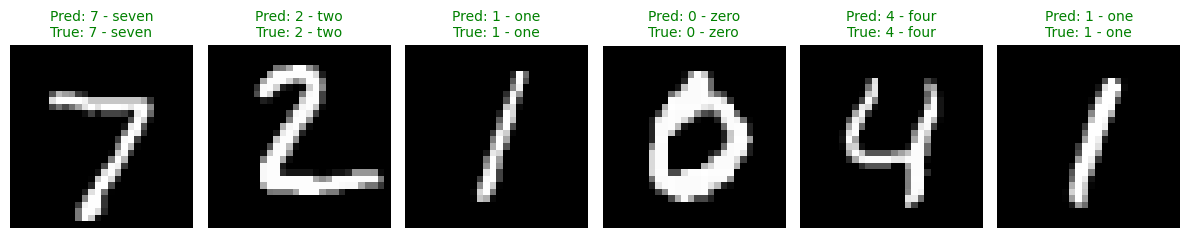

In [66]:
show_predictions(model_0, test_dataloader, class_names, device)

In [67]:
# Saving the model
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "handwritten_digits_conv_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save model state dict
print(f"Saving model to ⏳ {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

Saving model to ⏳ models/handwritten_digits_conv_model.pth


# **Conclusion**
After experimenting with different variations of the TinyVGG model, including one with dropout layers, I observed that the version **without dropout layers consistently achieved higher accuracy**. Based on these results, I have decided to use the model without dropout, as it performs better for this classification task.
